In [ ]:
import numpy as np
import pandas as pd

# Stable Diffusion: Code
# Introduction
So far, we have discussed the theory and architecture behind simple image generation models and understood the process behind diffusion models. We have seen the different components such as the autoencoder, scheduler, U-net and so on and the roles they play in the process of creating images using diffusion models.

In this session, you will look at the same Stable Diffusion model in a more practical manner. We will take the implementation of Stable Diffusion provided by HuggingFace and take a look at the different components that make it work.

You can find the documentation for the diffusers library [here](https://huggingface.co/docs/diffusers/index).

Credit to [Johno Whittaker](https://github.com/johnowhitaker) for his [Stable Diffusion Deep Dive](https://www.youtube.com/watch?v=844LY0vYQhc) notebook that worked as the basis for this notebook.

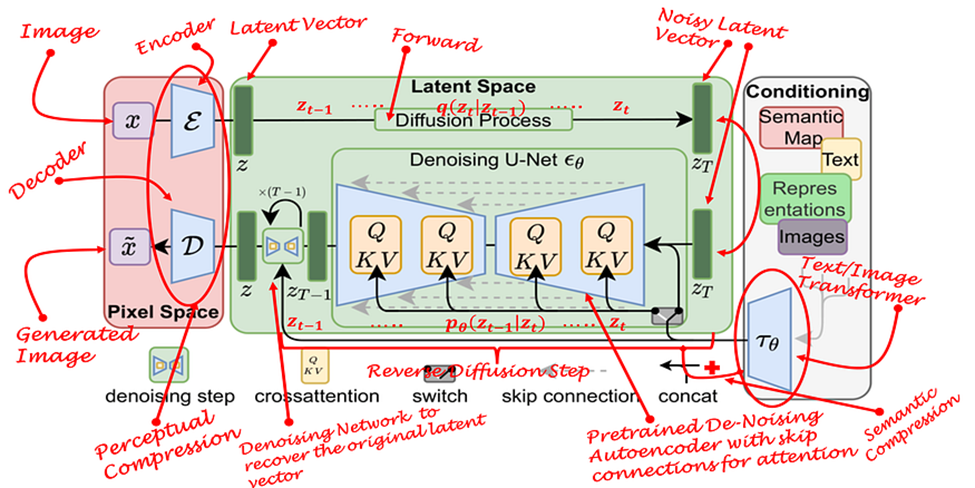

# A look behind the curtain
Going forward we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by recreating the functionality of generating an image as a scary chunk of code. We will then inspect the different components one-by-one and figure out what they do. By the end of this session, generating images using diffusion models should feel like something you can tweak and modify as you like.

## Setup and imports
When you run this notebook for the first time, you need to uncomment the following cells to install the requirements.

# Purpose of Libraries

- **transformers**: The `transformers` library by Hugging Face provides tools for working with pre-trained models for Natural Language Processing (NLP). It supports a wide range of models including BERT, GPT, and more, and facilitates tasks like text classification, text generation, and translation.

- **diffusers**: The `diffusers` library, also by Hugging Face, is designed for working with diffusion models, which are a type of generative model used for image synthesis. It simplifies the process of creating and training diffusion models.

- **ftfy**: The `ftfy` (Fix Text For You) library is used to automatically correct text encoding issues. It helps in fixing common text problems like Unicode errors and is useful for cleaning up and preprocessing text data.

- **accelerate**: The `accelerate` library by Hugging Face provides tools for easily training and running models on different hardware setups, such as CPUs, GPUs, and TPUs. It simplifies the process of managing hardware acceleration and parallelization in machine learning workflows.


From the install statements, you can see that the `diffusers` library uses `pytorch` to implement neural networks. The syntax of `tensorflow` and `pytorch` are quite similar, so if you are familiar with either of these libraries, you should be able to follow along with this code.

Please note that the computations are being sent to **cuda** which refers to the NVIDIA GPU. So make sure that you are connected to a T4 GPU on colab. You can connect to a GPU using the menu as follows:

> Runtime > Change runtime type > Hardware Accelerator: GPU

By default, Colab will connect you to an NVIDIA Tesla-4 GPU.

To check the configuration of the GPU provided by Google Colab in their VM, you can run the following code cell.

In [ ]:
!nvidia-smi

Sun Sep 15 03:33:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

You can learn more about how to interpret this output [here](https://medium.com/analytics-vidhya/explained-output-of-nvidia-smi-utility-fc4fbee3b124).
<br><br>

Let's now import the required methods and libraries.

# Code Explanation

```python
from base64 import b64encode  # Encodes binary data to Base64 encoding, often used for data transmission.
import numpy  # Imports the `numpy` library for numerical operations on arrays and matrices.
import torch  # Imports the `torch` library for deep learning and tensor computation.

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel  # Imports components from the `diffusers` library: autoencoder, scheduler, and UNet model.
# Explanation of Diffusers Components
AutoencoderKL  # A type of autoencoder used in diffusion models to learn compressed representations of data. It employs a Kullback-Leibler divergence loss to regularize the latent space.
LMSDiscreteScheduler  # A scheduler used to control the diffusion process, adjusting how noise is added or removed during training and inference. It typically uses a linear or discrete schedule.
UNet2DConditionModel  # A U-Net architecture adapted for conditional diffusion models. It is used for tasks like image generation, where the model conditions on some input (e.g., text or another image).


from torch import autocast  # Imports `autocast` from `torch` to automatically handle mixed-precision calculations.
from torchvision import transforms as tfms  # Imports image transformation functions from `torchvision` and renames it as `tfms` for convenience.
from tqdm.auto import tqdm  # Imports the `tqdm` library to display progress bars in loops.
from transformers import CLIPTextModel, CLIPTokenizer, logging  # Imports CLIP text model, tokenizer, and logging utilities from the `transformers` library.

from huggingface_hub import notebook_login  # Imports `notebook_login` to authenticate and access Hugging Face resources.

from IPython.display import HTML  # Imports `HTML` to display HTML content in Jupyter notebooks.
from matplotlib import pyplot as plt  # Imports `pyplot` from `matplotlib` for creating plots and visualizations.
from pathlib import Path  # Imports `Path` from `pathlib` for handling file paths.
from PIL import Image  # Imports `Image` from the Python Imaging Library (PIL) to handle image processing.
import os  # Imports the `os` library for interacting with the operating system.

torch.manual_seed(1)  # Sets the random seed for reproducibility in PyTorch operations.

logging.set_verbosity_error()  # Sets the logging level to suppress warnings and show only errors.

torch_device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'  # Determines the device to be used for computations: CUDA (GPU), MPS (Apple Silicon), or CPU.
if 'mps' == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'  # Enables fallback to CPU if MPS is unavailable on Apple Silicon devices.


In [ ]:
!pip install diffusers
# Import required libraries
from base64 import b64encode #Encodes binary data to Base64 encoding, often used for data transmission.

import numpy
import torch

# Import components of the Stable Diffusion model
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel #This line imports necessary modules from the diffusers library, which needs to be installed first.
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

# Import the method required to provide huggingface token
from huggingface_hub import notebook_login

# Import libraries required to display video
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import os

# Setting the seed to 1
torch.manual_seed(1)

# Supress some unnecessary warnings
logging.set_verbosity_error()

# Set the device that will be used by Pytorch to execute neural networks
torch_device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
if 'mps' == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

Now that you have imported the required modules, you will need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. To do this, you need to run the following code cell, click on the link that comes up in the output, and then create a token. Once you have pasted the token in the textbox, you will be ready to use this model.

In [ ]:
notebook_login()

In [ ]:
# Log into the huggingface using a token
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

You can see that we have made sure that the required libraries are installed. Then, we imported a few different modules which make up the whole Stable Diffusion pipeline which we will explore one-by-one. Note that we will be exploring the model stable-diffusion-v1-4 for this session. Stable Diffusion v2.1 has some additional components that you can explore on your own.

## Generating an image

Next we will generate an image without the convenient wrapper provided by the diffusers library. For this, we will first download and setup relevant components which are needed to generate an image. We will look at each component in this code one by one later.

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

Let's start by downloading the following models:
1. **Variational Autoencoder**: This model is used to encode and decode images to a latent space
2. **Tokenizer**: This model is used to break down the text prompt into individual tokens. The model being used to create these tokens is called the CLIPText model.
3. **Text Encoder**: This model is used to convert the tokenized text into text embeddings. The model being used to create these text embeddings is called the CLIPText model.
4. **UNet Model**: This is the model that does the actual prediction. The pretrained model is made available with stable diffusion v1.4.

You should be familiar with these components from the theoretical discussion of the Stable Diffusion model.

# How CLIPText Model Works

1. **Text Embeddings**:
   - **Input**: The model takes text inputs, which are first tokenized into subword units using a tokenizer (e.g., CLIPTokenizer).
   - **Embedding**: The tokens are then converted into dense vectors (embeddings) using an embedding layer.
   - **Contextualization**: These embeddings are passed through a Transformer-based network (e.g., the CLIPTextModel), which processes them to capture contextual relationships and generate a fixed-size representation of the text.

2. **Text Representation**:
   - **Output**: The model produces a high-dimensional vector (embedding) that represents the input text. This vector captures the semantic meaning of the text.

3. **Contrastive Learning**:
   - **Objective**: CLIP models are trained using a contrastive loss function, where the goal is to maximize the similarity between matching text-image pairs while minimizing the similarity between non-matching pairs.
   - **Training**: During training, the CLIPText model learns to produce text embeddings that are aligned with the embeddings produced by the CLIP image model for corresponding images.

4. **Usage**:
   - **Text-to-Image Matching**: The text embeddings can be used to find or generate images that match a given text description.
   - **Zero-Shot Learning**: The model can generalize to new tasks without additional training by leveraging the learned relationships between text and images.

By using a shared embedding space for both text and images, CLIP enables the model to understand and relate textual and visual information effectively.


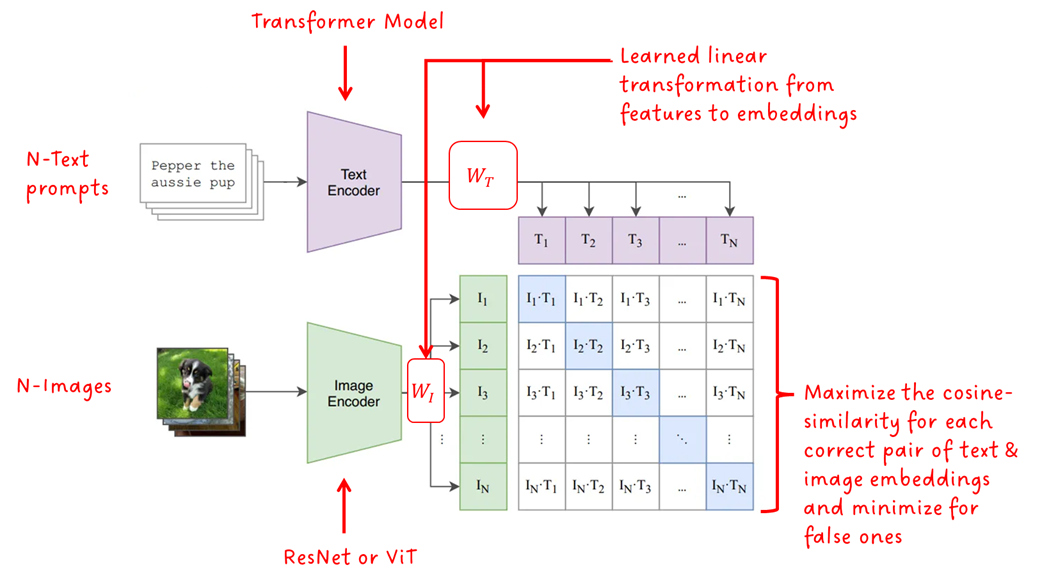

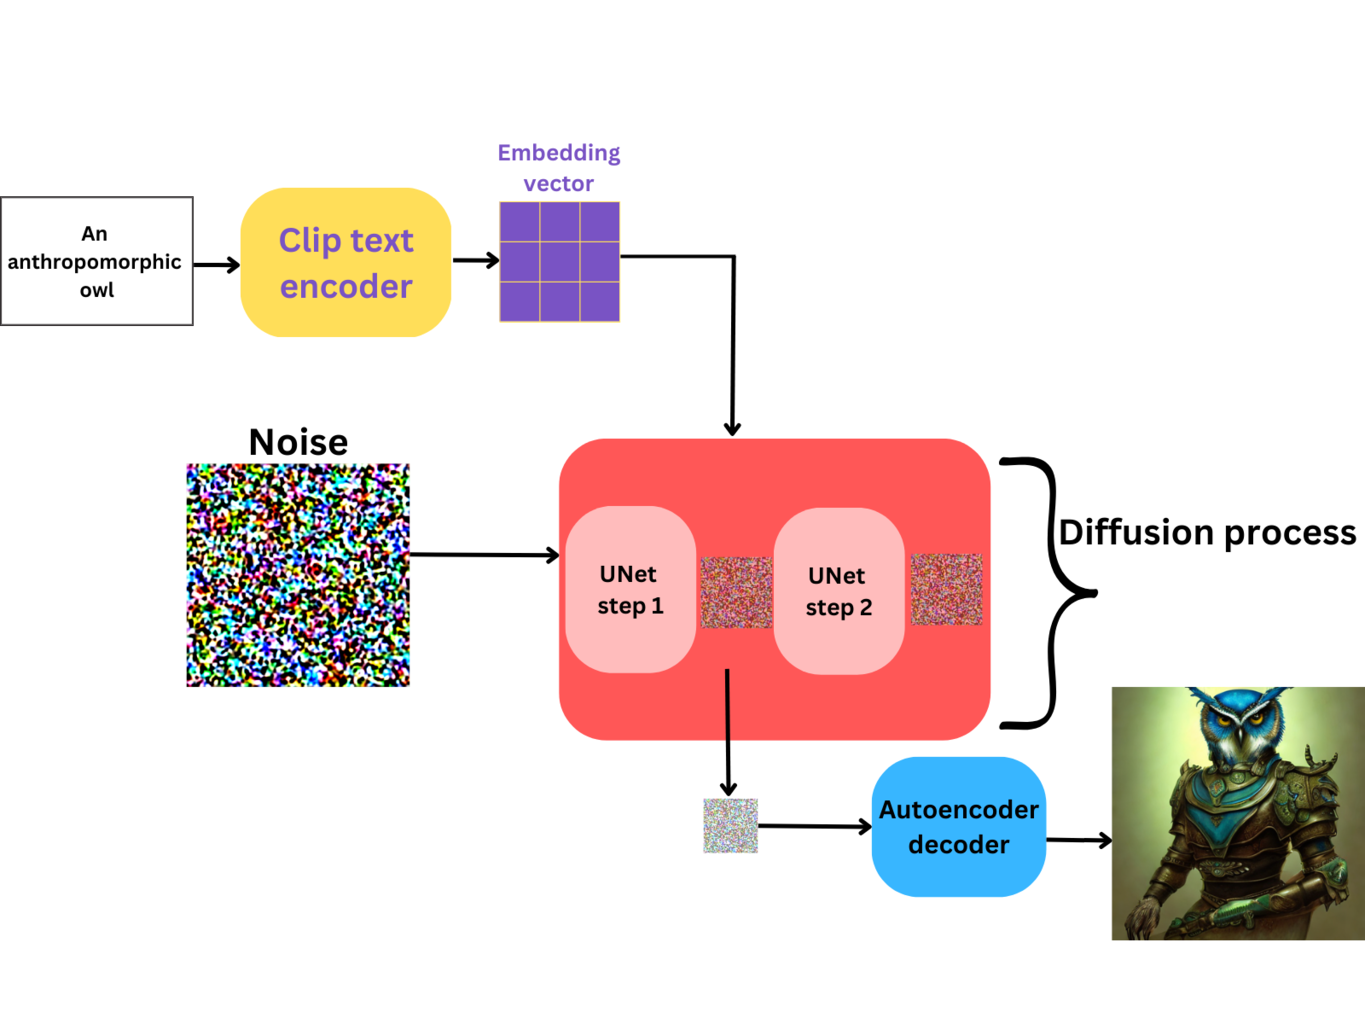

## https://huggingface.co/blog/stable_diffusion#how-does-stable-diffusion-work

# [Clip_model](https://youtu.be/jXD6O93Ptks?si=r8GCUjvHOfyD1bui)

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space
vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder = 'vae')

# Load the tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')

# The UNet model for generating the latents
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder = 'unet')

After downloading the models, we will set them up so that they use the GPU.

In [ ]:
# Setting the models such that they use the GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Finally, before moving on to the code used to generate images, we will initialize the noise scheduler that will be used to noise and denoise images.

# Explanation of the Noise Scheduler

```python
scheduler = LMSDiscreteScheduler(
    beta_start = 0.00085,  # The starting value of the noise variance (beta) for the diffusion process.
    beta_end = 0.012,      # The ending value of the noise variance (beta) for the diffusion process.
    beta_schedule = 'scaled_linear',  # The type of schedule used to vary the noise variance over time. 'scaled_linear' means the variance increases linearly based on a scaling factor.
    num_train_timesteps = 1000  # The total number of time steps in the diffusion process. This determines how many discrete steps the scheduler will use.
)


In [ ]:
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = 'scaled_linear', num_train_timesteps = 1000)

## A diffusion loop
Next, we will use code adapted from the [`__call__()`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200) method of the stable diffusion pipeline to create an image. This means, this is the code that is executed when we call the `pipe()` method with a prompt.

We will explore each component referred to in this code individually. For now, try to identify the different components that you are familiar with and see how they are working together.

# Explanation of Code Snippet

## `with torch.no_grad():`

**Purpose**: This context manager is used to temporarily disable gradient computation. It is useful during inference or evaluation to save memory and computations, as gradients are not needed for forward passes when you are not training the model.

**Effect**: Operations inside this block will not track gradients, making them more efficient.

## `text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]:`

**`text_input.input_ids.to(torch_device)`**: Moves the input IDs tensor to the specified device (e.g., GPU or CPU) for processing.

**`text_encoder(text_input.input_ids.to(torch_device))`**: Passes the input IDs through the `text_encoder` model to get the embeddings. The `text_encoder` is typically a model like CLIP or BERT that transforms text inputs into embeddings.

**`[0]`**: Extracts the first element of the model's output. For many models, this is the actual embeddings tensor, while the second element might contain additional information like attention weights.

## `max_length = text_input.input_ids.shape[-1]:`

**Purpose**: Determines the maximum sequence length of the input text sequences.

**`text_input.input_ids.shape[-1]`**: Accesses the size of the last dimension of the `input_ids` tensor, which represents the sequence length. This is useful for understanding or managing input dimensions.


# Explanation of `torch.cat` Usage

## `text_embeddings = torch.cat([uncond_embeddings, text_embeddings])`

**Purpose**: This line concatenates two tensors along a specified dimension. It combines `uncond_embeddings` and `text_embeddings` into a single tensor.

**Details**:

- **`torch.cat([...])`**: The `torch.cat` function concatenates a sequence of tensors along a given dimension. By default, it concatenates along the first dimension (dim=0).

- **`[uncond_embeddings, text_embeddings]`**: The list of tensors to be concatenated. Here, `uncond_embeddings` and `text_embeddings` are the tensors being combined.

  - **`uncond_embeddings`**: Likely contains embeddings related to some unconditional or default input, such as a generic or neutral condition.
  - **`text_embeddings`**: Contains embeddings derived from specific text inputs.

- **`text_embeddings`**: The resulting tensor after concatenation. This new tensor contains the embeddings from both `uncond_embeddings` and `text_embeddings`, combined along the specified dimension.

**Effect**: The concatenation results in a single tensor that includes the embeddings from both sources, which can be useful for tasks where both unconditional and specific text embeddings are needed together, such as in models that combine multiple types of embeddings for further processing.


# Code Explanation

```python
# Set up the scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)  # Configures the scheduler with the number of inference steps.
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)  # Converts the timesteps tensor to float32 for precision.

set_timesteps(scheduler, num_inference_steps)  # Calls the function to configure the scheduler with the specified number of inference steps.

# Create the latent noise values that will be used to generate images
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)  # Generates random noise tensors of the required shape, used as initial latent variables for image generation.
latents = latents.to(torch_device)  # Moves the latents tensor to the specified device (GPU or CPU).
latents = latents * scheduler.init_noise_sigma  # Scales the latents by the initial noise sigma for proper noise levels.

# Main diffusion loop
with autocast('cuda'):  # Uses mixed-precision computation to save memory and improve performance on CUDA devices; falls back to CPU if CUDA is not available.
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):  # Iterates through timesteps with a progress bar.
        latent_model_input = torch.cat([latents] * 2)  # Duplicates the latents tensor to support classifier-free guidance, which helps in avoiding two forward passes.
        sigma = scheduler.sigmas[i]  # Retrieves the current noise level sigma for the timestep.
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)  # Scales the model input according to the scheduler’s scaling function.

        with torch.no_grad():  # Disables gradient computation to save memory during inference.
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample  # Predicts the noise residual using the UNet model.

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)  # Splits the noise prediction into unconditional and conditional components.
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)  # Applies classifier-free guidance to enhance the conditional prediction.

        latents = scheduler.step(noise_pred, t, latents).prev_sample  # Updates the latents tensor by stepping the scheduler to the previous sample.

# Scale and decode the image latents with VAE
latents = 1 / 0.18215 * latents  # Scales the latents tensor to the correct range for decoding.
with torch.no_grad():  # Disables gradient computation during decoding.
    image = vae.decode(latents).sample  # Decodes the latents into image tensors using the VAE model.

# Display
image = (image / 2 + 0.5).clamp(0, 1)  # Rescales the image tensor to the range [0, 1] and clamps values to ensure they are within this range.
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()  # Moves the image tensor to the CPU, detaches it from the computation graph, permutes dimensions for image format, and converts it to a NumPy array.
images = (image * 255).round().astype('uint8')  # Scales the image to the range [0, 255], rounds to integers, and converts to unsigned 8-bit integers.
pil_images = [Image.fromarray(image) for image in images]  # Converts NumPy arrays to PIL Image objects.
pil_images[0]  # Retrieves the first image from the list of PIL images.
```

<ipython-input-34-cdd559ef03e4>:33: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

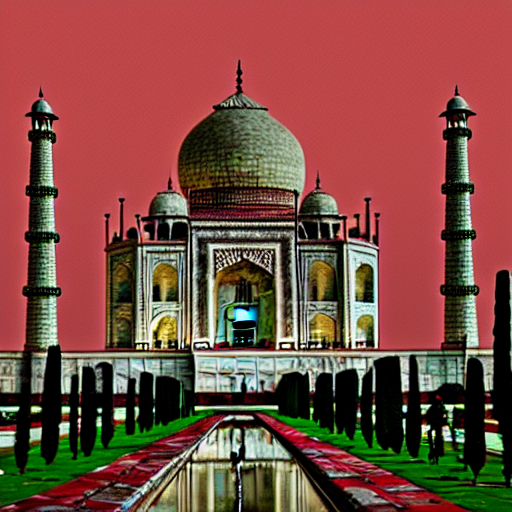

In [ ]:
# Set up the parameters required for image generation
# Set up the parameters required for image generation
prompt = ['Taj mahal in black']
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance     #how close imgaeshould be to prompt 7-9
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1                      # Here only one image create thats why we take batch_size = 1

# Tokenize text
text_input = tokenizer(prompt, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')

# Convert tokenized text into text embeddings
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]

# Create unconditioned embeddings that will be used for classifier free guidance
uncond_input = tokenizer([''] * batch_size, padding = 'max_length', max_length = max_length, return_tensors = 'pt')
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Set up the scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler,num_inference_steps)

# Create the latent noise values that will be used to generate images
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                      generator = generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Main diffusion loop
with autocast('cuda'):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
        # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample

        # Perform classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)['prev_sample'] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype('uint8')
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

It's working, but that's quite a bit of code! Let's look at the components one by one.

# Components of the Stable Diffusion pipeline
Let's now explore the different components that make up the Stable Diffusion Pipeline one-by-one.

## Variational Autoencoder (VAE)
The VAE can encode an image into some sort of latent representation, and decode this back into an image. Given below are two functions that convert an image into a latent space (`pil_to_latent()`) and convert an object from the latent space back to an image (`latents_to_pil()`).

Why do we even use an autoencoder? We can do diffusion in pixel space - where the model gets all the image data as inputs and produces an output prediction of the same shape. But this means processing a LOT of data, and make high-resolution generation very computationally expensive. But latent diffusion instead does the diffusion process in this **latent space**, using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels.

In [ ]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 - 1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Notice that the `pil_to_latent()` function creates a distribution in the latent space using the encoder part of a variational autoencoder. To get a point, we sample from that distribution. Due to some technical reasons that are beyond this discussion, we multiply the sampled point by 0.18125 before returning it.

The `latents_to_pil()` function reverses this using the decoder part of the variational autoencoder. Then we need to perform some resizing operations before we get the actual image.
<br><br>

Let's now try this function on an image and see what the latent values look like.

In [ ]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   120k      0 --:--:-- --:--:-- --:--:--  119k


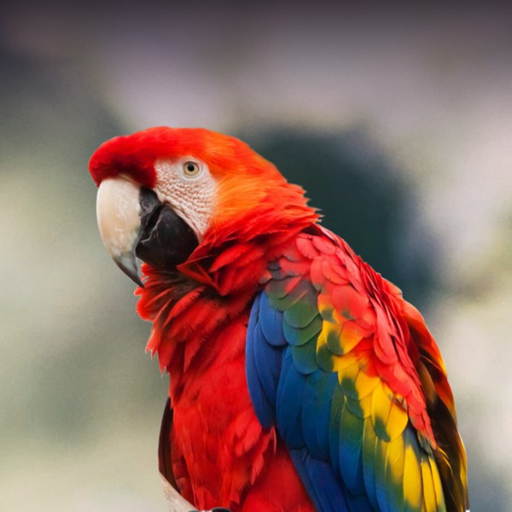

In [ ]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encoding this into the latent space of the AE with the function defined above looks like this:

In [ ]:
input_image.size

(512, 512)

In [ ]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

You can see that the original image was of the size (512,512,3) and after encoding, its new size is (4,64,64). Let's now visualize these latent space representations.

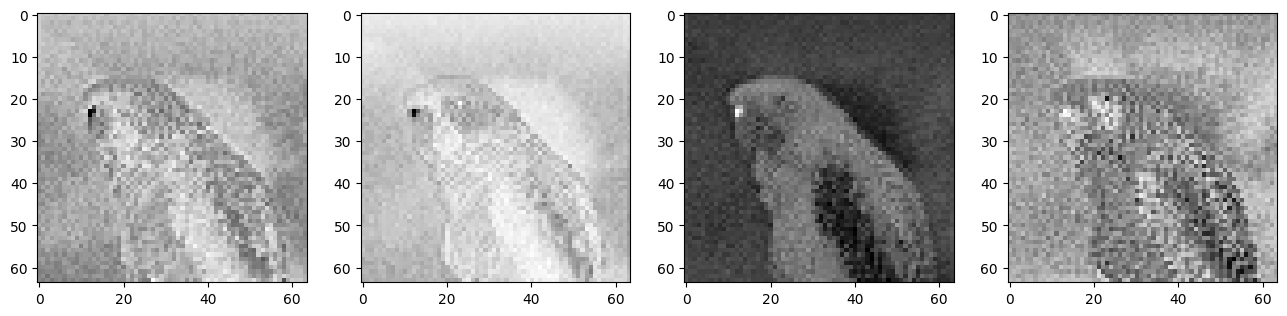

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap = 'Greys')

This 4x64x64 tensor captures lots of information about the image, hopefully enough that when we feed it through the decoder we get back something very close to our input image:

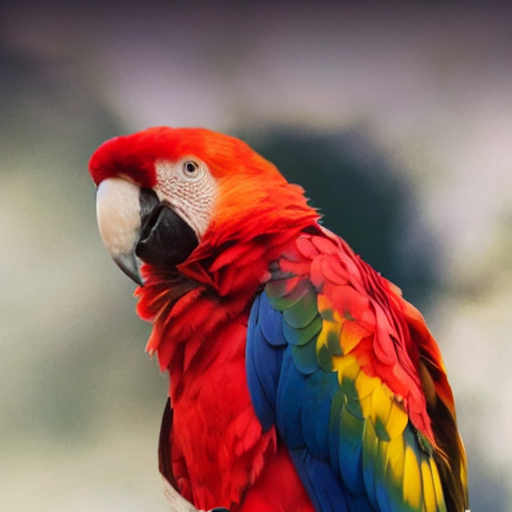

In [ ]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

You'll see some small differences if you squint! Forcus on the eye if you can't see anything obvious. This is pretty impressive - that 4x64x64 latent seems to hold a lot more information that a 512x512 (original is bigger) image.

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again.

In this particular case the compression factor is 48, we start with a 3x512x512 (ch x ht x wd) image and it get compressed to a latent vector 4x64x64. Each 3x8x8 pixel volume in the input image gets compressed down to just 4 numbers (4x1x1).

## Scheduler
The next component that we will talk about is the scheduler. It is used to add noise to an image.

As you may have seen before, during training, we add some noise to an image an then have the model try to predict the noise. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.

During sampling, we want to **denoise** over a number of steps. How many steps and how much noise we should aim for at each step are going to affect the final result.

The scheduler is in charge of handling all of these details. We have already instantiated our scheduler using the statement:

`scheduler = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = 'scaled_linear', num_train_timesteps = 1000)`

This initialisation statement tells the model to use the scaled linear schedule to create 1000 noise values based on values of beta ranging from 0.00085 to 0.012.

You can read more about this scheduler [here](https://huggingface.co/docs/diffusers/api/schedulers/lms_discrete).

Here, we have specified the value of the parameter beta (one that is used to control the amount of noise).

This sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with `scheduler.set_timesteps`. This means that even though the model was trained with 1000 steps in the diffusion process, we can create an image using the model using a smaller number of steps.

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = 'scaled_linear', num_train_timesteps = 1000)
# Setting the number of sampling steps
set_timesteps(scheduler, 15)


You can see how our new set of steps corresponds to those used in training.

In [ ]:
# See these in terms of the original 1000 steps used for training
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])


We can also plot these values.

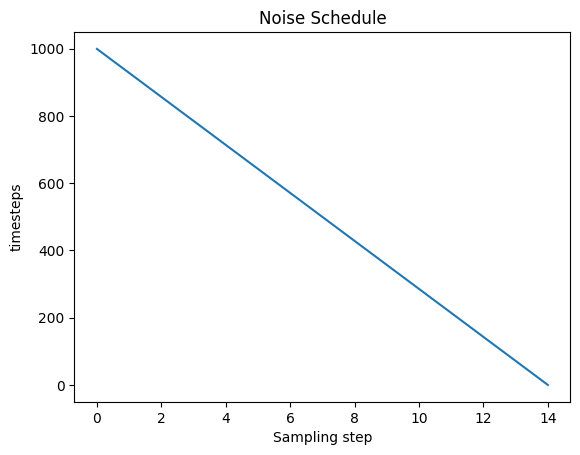

In [ ]:
# Plotting this noise schedule:
plt.plot(scheduler.timesteps)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('timesteps')
plt.show()

Let's now look at the amount of noise that is removed in each step. This is represented by the sigma value. The sigma values are calculated based on the parameters which were used to setup the scheduler.

In [ ]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


During sampling, we'll start at a high noise level (in fact, our input will be pure noise) and gradually denoise down to an image, according to this schedule.

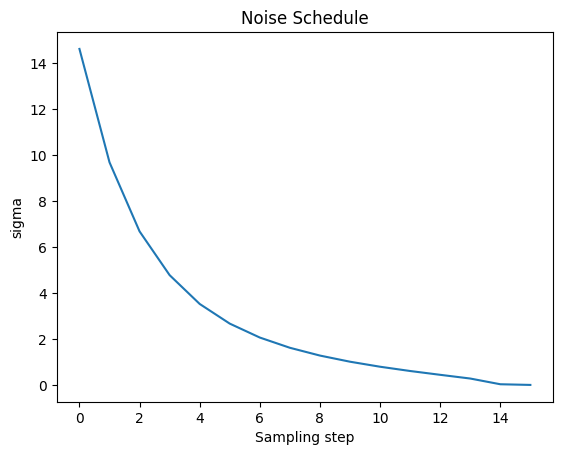

In [ ]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

In [ ]:
scheduler.timesteps[14]

tensor(0.)

You can also see the rate at which the scheduler's timesteps vary based on the sampling steps.

This sigma is the amount of noise added to the latent representation.
<br><br>

Let's visualize what this looks like by adding a bit of noise to our encoded image and then decoding this noised version.

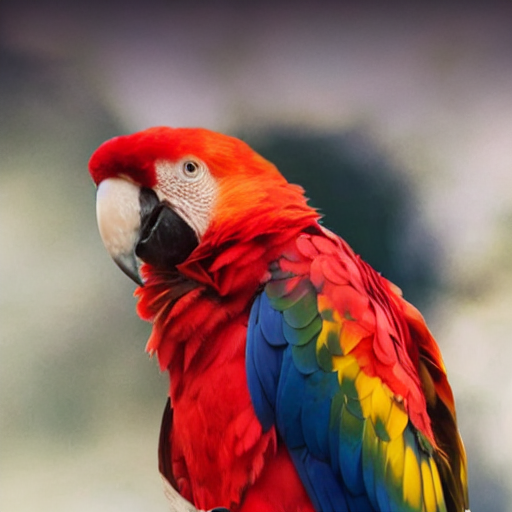

In [ ]:
# Creating random noise in the shape of the encoded image
noise = torch.randn_like(encoded)

# Equivalent to sep 10 out of 15 in the schedule above
sampling_step = 14

# Adding noise to the encoded image
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[sampling_step]]))

# Removing noise and visualizing the image
latents_to_pil(encoded_and_noised.float())[0]

To visualize what the image might look like at different step in the denoising process, you can change the value of the `sampling_step` variable and recreate this image.

### Loop starting from noised version of input (AKA image2image)

Let's now take a detour to get better insight into how the denoising process works. To do this, we will use the image that we generated in the previous step as a starting point, add some noise to it, and then perform the final few denoising steps with a new prompt.

This should result in an image that is partially similar to the starting image of the parrot and partially conforms to the prompt.

We'll use a similar loop to the first demo, but we'll skip the first `start_step` steps.

To noise our image we'll use code like that shown above, using the scheduler to noise it to a level equivalent to step 10 (`start_step`).

  0%|          | 0/50 [00:00<?, ?it/s]

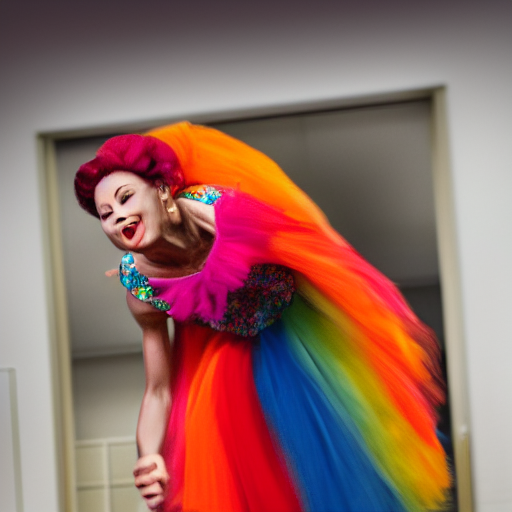

In [ ]:
# # Set up the parameters required for image generation (same as before except for the new prompt)
prompt = ['A colorful lady, dancing']
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Tokenize text (same as before)
text_input = tokenizer(prompt, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')




# Convert tokenized text into text embeddings
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]

# Create unconditioned embeddings that will be used for classifier free guidance
uncond_input = tokenizer([''] * batch_size, padding = 'max_length', max_length = max_length, return_tensors = 'pt')
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Set up the scheduler (setting the number of inference steps)
set_timesteps(scheduler, num_inference_steps)

# Prep latents (noising appropriately for start_step)
# In the previous diffusion loop, we started with a noisy vector of appropriate size
# Instead of that, we are starting with a noisy image with the amount of noise appropriate to start_step = 10
start_step = 12
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)['sample']

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

initally - the subject (noise) if noise is too much the content effect is little
if the noise is little, the content effect is significant. Certain features will leak to the final image

You can see that some colours and structure from the image are kept, but we now have a new picture! The more noise you add and the more steps you do, the further away it gets from the input image.

This is how the popular **img2img** pipeline works. Again, if this is your end goal there are tools to make this easy!

But you can see that under the hood this is the same as the generation loop just skipping the first few steps and starting from a noised image rather than pure noise.

Explore changing how many steps are skipped and see how this affects the amount the image changes from the input.

## Text embeddings
So far we have looked at the autoencoder, the scheduler and a few examples of the denoising process. Next, we will explore the process for generating text embeddings. For this, we use a text encoder model to turn our text into a set of embeddings which are fed to the diffusion model as conditioning. Let's follow a piece of text through this process and see how it works.

In [ ]:
# Our text prompt
prompt = 'A picture of a puppy' #<sos> a, picture of a puppy <eos> <eos> <eos> ....

Recall at the top of this notebook, we downloaded two models: CLIPTokenizer abd CLIPTextModel. These two models perform two separate functions:
1. The tokenizer converts words into tokens which, in essence, are numerical representations of those words.
2. The text encoder model converts those tokens into high dimensional embeddings which can be sent into the transformer model to generate output embeddings.
<br><br>

Let's begin with tokenization.

In [ ]:
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

Here, you can see that only the first 6 tokens are different, the rest of them are the same. Let's see what those tokens are.

In [ ]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


After tokenizing, we can obtain the output embeddings using `text_encoder()` model.

In [ ]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

We pass our tokens through the text_encoder and we magically get some numbers we can feed to the model.

How are these generated? The tokens are transformed into a set of input embeddings, which are then fed through the transformer model to get the final output embeddings.

To get these input embeddings, there are actually two steps - as revealed by inspecting `text_encoder.text_model.embeddings`:

In [ ]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

Let's now take a look at both of these embeddings one by one.

### Token embeddings

The token is fed to the `token_embedding` to transform it into a vector. The function name `get_input_embeddings` here is misleading since these token embeddings need to be combined with the position embeddings before they are actually used as inputs to the model! Anyway, let's look at just the token embedding part first.

In [ ]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

And embed a token like so.

In [ ]:
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(6829, device = torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

This single token has been mapped to a 768-dimensional vector - the token embedding.

We can do the same with all of the tokens in the prompt to get all the token embeddings:

In [ ]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Positional Embeddings

Positional embeddings tell the model where in a sequence a token is. Much like the token embedding, this is a set of (optionally learnable) parameters. But now instead of dealing with ~50k tokens we just need one for each position (77 total).

In [ ]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

We can get the positional embedding for each position.

In [ ]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Combining token and position embeddings

Time to combine the two. How do we do this? Just add them! Other approaches are possible but for this model this is how it is done.

Combining them in this way gives us the final input embeddings ready to feed through the transformer model.

In [ ]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

But we can generate our input embeddings using `text_encoder.text_model.embeddings` method.

In [ ]:
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

### Feeding these through the transformer model
We have now created input embeddings. These input embeddings are then sent through a transformer model which converts them into output embeddings. These output embeddings are used with the UNet to guide the denoising process in diffusion.

To convert the input embeddings to output embeddings, we will used the function defined below, namely `get_output_embeds()`. You don't need to understand everything that is going on inside this function. Just know that this function sends the input embeddings into a transformer model and returns output embeddings.

This code is taken from the `text_encoder.text_model.forward` method. You can examine the code for yourself by typing `??text_encoder.text_model.forward` into a code cell.

In [ ]:
import torch

def get_output_embeds(input_embeddings):
    # Converts input embeddings into output embeddings
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]

    # Manually create the causal attention mask and adjust its shape
    causal_attention_mask = torch.tril(torch.ones((seq_len, seq_len), device=input_embeddings.device))
    causal_attention_mask = causal_attention_mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
    causal_attention_mask = causal_attention_mask.repeat(bsz, 1, 1, 1)  # Adjust to batch size
    causal_attention_mask = causal_attention_mask.to(dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,  # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask,
        output_attentions=None,
        output_hidden_states=True,  # We want the output embs not the final output
        return_dict=None
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

# Test the function
out_embs_test = get_output_embeds(input_embeddings)  # Feed through the model with our new function
print(out_embs_test.shape)  # Check the output shape
out_embs_test  # Inspect the output


torch.Size([1, 77, 768])


tensor([[[-0.3393,  0.0331, -0.1261,  ..., -0.3537, -0.3191,  0.0622],
         [ 0.0037, -1.3590,  0.4004,  ...,  1.7676, -0.2924, -0.7304],
         [ 0.0298, -1.3812,  0.5021,  ...,  1.8536, -0.2638, -0.5424],
         ...,
         [ 0.3467, -0.8605,  0.0941,  ...,  2.1394, -0.7441, -0.5529],
         [ 0.3391, -0.8473,  0.0928,  ...,  2.1614, -0.7567, -0.5530],
         [ 0.3786, -0.7866,  0.1186,  ...,  2.1692, -0.7021, -0.5931]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

Now that we have this process in place, let's take a detour to understand the concept of replacing the input embedding of a token with a new one of our choice. To demonstrate the concept, let's replace the input embedding for **puppy** in the prompt we've been playing with with the embedding for token 2368, get a new set of output embeddings based on this, and use these to generate an image to see what we get.

In [ ]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 2368...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device = torch_device))

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

The first few are the same, the last aren't. Everything at and after the position of the token we're replacing will be affected.

If all went well, we should see something other than a puppy when we use these to generate an image.

To generate an image from output embeddings, we will define a function `generate_with_embs()`. This function takes some code from the `call()` method of the Stable Diffusion pipeline. Similar to the large chunk of code that we used to create our first image.

### Modified embeddings

In [ ]:
# Generating an image with these modified embeddings
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]

    # We don't need to tokenize or encode our text as we are taking embeddings as input to this method
    # Create unconditioned embeddings that will be used for classifier free guidance
    uncond_input = tokenizer([''] * batch_size, padding = 'max_length', max_length = max_length, return_tensors = 'pt')
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Set up the scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Create the latent noise values that will be used to generate images
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                          generator = generator)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Main diffusion loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
        # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)['sample']

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [ ]:
generate_with_embs(modified_output_embeddings)

NameError: name 'modified_output_embeddings' is not defined

Suprise! Now you know what token 2368 means ;)

**What can we do with this?** Why did we go to all of this trouble? Well, we'll see a more compelling use-case shortly but the tl;dr is that once we can access and modify the token embeddings we can do tricks like replacing them with something else. In the example we just did, that was just another token embedding from the model's vocabulary, equivalent to just editing the prompt. But we can also mix tokens - for example, here's a half-puppy-half-skunk:

In [ ]:
# In case you're wondering how to get the token for a word, or the embedding for a token:
prompt = 'skunk'
print('tokenizer(prompt):', tokenizer(prompt))
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([8797], device = torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape: torch.Size([1, 768])


<ipython-input-69-f54af79ea565>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

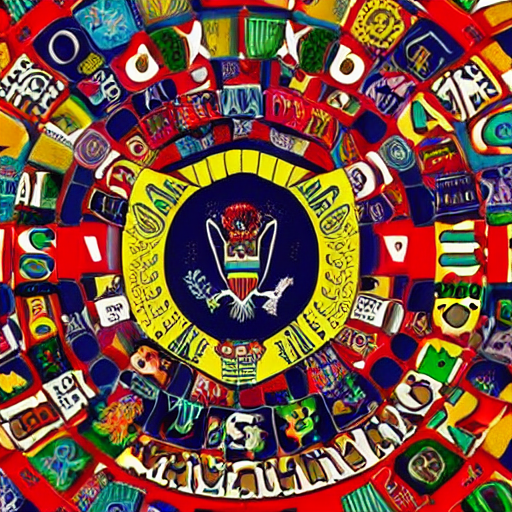

In [ ]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device = torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194, device = torch_device))
replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

# Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)

## The UNET and Classifier free guidance
Now it's time we looked at the actual diffusion model. This is typically a UNet that takes in the noisy latents (x) and predicts the noise. We use a conditional model that also takes in the timestep (t) and our text embedding (aka encoder_hidden_states) as conditioning. Feeding all of these into the model looks like this:
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`
<br><br>

We can try it out and see what the output looks like.

In [ ]:
# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# What is our timestep
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# A noisy latent
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                      generator = generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Text embedding
text_input = tokenizer(['A macaw'], padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run this through the unet to predict the noise residual
with torch.no_grad():
    noise_pred = unet(latents, t, encoder_hidden_states = text_embeddings)['sample']

latents.shape, noise_pred.shape # We get preds in the same shape as the input

Given a set of noisy latents, the model predicts the noise component. We can remove this noise from the noisy latents to see what the output image looks like (`latents_x0 = latents - sigma * noise_pred`). And we can add most of the noise back to this predicted output to get the (slightly less noisy hopefully) input for the next diffusion step. To visualize this let's generate another image, saving both the predicted output (x0) and the next step (xt-1) after every step:

In [ ]:
prompt = 'Oil painting of an otter in a top hat'
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text
text_input = tokenizer([prompt], padding = 'max_length', max_length = tokenizer.model_max_length, truncation = True, return_tensors = 'pt')
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([''] * batch_size, padding = 'max_length', max_length = max_length, return_tensors='pt')
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                      generator = generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma
print(len(tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps))))

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):
    # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)['sample']

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Get the predicted x0
    latents_x0 = latents - sigma * noise_pred
    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpg')

In [ ]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The version on the right shows the **predicted final output** (x0) at each step, and this is what is usually used for progress videos etc. The version on the left is the **next step**. I found it interesteing to compare the two - watching the progress videos only you'd think drastic changes are happening expecially at early stages, but since the changes made per-step are relatively small the actual process is much more gradual.



### Classifier Free Guidance

By default, the model doesn't often do what we ask. If we want it to follow the prompt better, we use a hack called CFG. There's a good explanation in this video [AI coffee break GLIDE](https://www.youtube.com/watch?v=344w5h24-h8).

In the code, this comes down to us doing:

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

This works suprisingly well :) Explore changing the guidance_scale in the code above and see how this affects the results. How high can you push it before the results get worse?

# Summary

In this session, you have taken a look at the different components of implementation of Stable Diffusion provided by Huggingface in their diffusers library.

You started with a large chunk of scary code that was used to create an image and then you looked at the different components of that code one-by-one. Starting with Variational Autoencoder, you saw that we covert the input image into a latent space representation before training our model. You learned about how text embeddings are created and how they are fed into the model. Finally, you learned about the UNet model and how we use classifier free guidance to guide the denoising process towards the image described by the text prompt.

You are now ready to tweak these different parts of the Stable Diffusion model to your own advantage.